In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import os
import PIL
import time

from tensorflow.keras import layers

from IPython import display

In [4]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5   #In order to normalize the images i.e.,[-1,1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
class Generator_Model(tf.keras.Model):
  def __init__(self):
    super(Generator_Model,self).__init__()
    self.dense_1 = layers.Dense(7*7*256,use_bias=False)
    self.batch_norm_1 = layers.BatchNormalization()
    self.leaky_relu_1 = layers.LeakyReLU()

    self.reshapor_1 = layers.Reshape([7,7,256])
    self.conv_1 = layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False)
    self.batch_norm_2 = layers.BatchNormalization()
    self.leaky_relu_2 = layers.LeakyReLU()

    self.conv_2 = layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False)
    self.batch_norm_3 = layers.BatchNormalization()
    self.leaky_relu_3 = layers.LeakyReLU()

    self.conv_3 = layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False)

  def call(self,x):
    x = self.dense_1(x)
    x = self.batch_norm_1(x)
    x = self.leaky_relu_1(x)

    x = self.reshapor_1(x)
    x = self.conv_1(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu_2(x)

    x = self.conv_2(x)
    x = self.batch_norm_3(x)
    x = self.leaky_relu_3(x)

    out = self.conv_3(x)

    return out


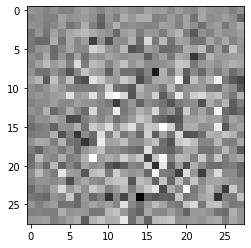

In [9]:
generator = Generator_Model()
noise = tf.random.normal([1,100])
generated_image=generator(noise)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [0]:
class Discriminator_Model(tf.keras.Model):
  def __init__(self):
    super(Discriminator_Model,self).__init__()

    self.conv_1 = layers.Conv2D(64,(5,5),strides=(2,2),padding='same')
    self.batch_norm_1 = layers.BatchNormalization()
    self.leaky_relu_1 = layers.LeakyReLU()
    self.drop_1 = layers.Dropout(0.3)

    self.conv_2 = layers.Conv2D(128,(5,5),strides=(2,2),padding='same')
    self.batch_norm_2=layers.BatchNormalization()
    self.leaky_relu_2 = layers.LeakyReLU()
    self.drop_2 = layers.Dropout(0.3)

    self.flatten = layers.Flatten()
    self.dense = layers.Dense(1)

  def call(self,x):
    x = self.conv_1(x)
    x = self.batch_norm_1(x)
    x = self.leaky_relu_1(x)
    x = self.drop_1(x)

    x = self.conv_2(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu_2(x)
    x = self.drop_2(x)

    flat = self.flatten(x)
    out = self.dense(flat)

    return out

In [11]:
discriminator = Discriminator_Model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00100221]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss+fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [0]:
def train_step(image):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_image=generator(noise)

    real_output = discriminator(image)
    fake_output = discriminator(generated_image)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  grads_gen = gen_tape.gradient(gen_loss,generator.trainable_variables)
  grads_disc = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(grads_gen,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(grads_disc,discriminator.trainable_variables))


In [0]:
def train(dataset,epochs):
    for epoch in range(epochs):
          start = time.time()

          for image_batch in dataset:
            train_step(image_batch)
          # Produce images for the GIF as we go
          display.clear_output(wait=True)
          generate_and_save_images(generator,
                                  epoch + 1,
                                  seed)
          # Save the model every 15 epochs
          if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

          print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [0]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


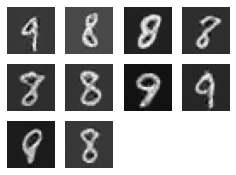

In [26]:
train(train_dataset,EPOCHS)

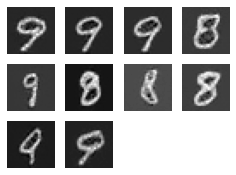

In [43]:
#Generating some new Images

images = 10
fig = plt.figure(figsize=(4,4))
for i in range(images):
    image = generator(tf.random.normal([1,100]))
    ax=fig.add_subplot(4,4,i+1)
    image = image[0,:,:,0]* 127.5 + 127.5
    ax.imshow(image,cmap='gray')
    plt.axis('off')